In [1]:
import pandas as pd
import numpy as np

In [2]:
# pd.set_option('precision',2)

import pandas as pd
import locale

# locale.setlocale( locale.LC_ALL, 'English_United States.1252')
# locale._override_localeconv = {'n_sign_posn':1}

In [60]:
get_ipython().magic('matplotlib inline')
import matplotlib.pylab as plt
import seaborn as sns
# import ggplot as gg
# from ggplot import *
import bokeh as bkh
from bokeh.layouts import row
from bokeh.plotting import figure, show, output_file

In [4]:
# dataset from https://www.kaggle.com/kaggle/sf-salaries
# sf2014
sf = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

# dataset from http://transparentcalifornia.com/salaries/2015/san-francisco/
# sf2015 = pd.read_csv('data/sf-salaries/san-francisco-2015.csv')

#### na_values=['Not Provided', 'Not provided', 'not provided']

In [5]:
# Combine the 2011-2014 dataset with 2015
# sf = pd.concat([sf2014, sf2015], ignore_index=True)


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


In [6]:
# sf2014.head()

### MENTOR ### Notice that the *sf 2011-2014" doesnt not have $ in TotalPay

In [7]:
# sf2015.head()

### MENTOR ### Notice that the *sf 2015" doesnt not have $ in TotalPay

## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [235]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,Unknown,POLICE,GARY
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,Unknown,POLICE,ALBERT
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,Unknown,,CHRISTOPHER
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,Unknown,FIRE,PATRICK
5,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,Unknown,,DAVID


In [8]:
sf.isnull().sum()

Id                   0
EmployeeName         6
JobTitle             4
BasePay            609
OvertimePay          4
OtherPay             4
Benefits         36163
TotalPay             0
Year                 0
Agency               0
Status          110535
dtype: int64

In [9]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [10]:
# del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [11]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
# sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [33]:
# Much cleaner now
sf.isnull().sum()

Id                0
EmployeeName      2
JobTitle          0
BasePay         605
OvertimePay       0
OtherPay          0
Benefits          0
TotalPay          0
Year              0
Status            0
dtype: int64

NOTE: From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

In [16]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay          object
OvertimePay      object
OtherPay         object
Benefits         object
TotalPay        float64
Year              int64
Status           object
dtype: object

Now we need to convert BasePay, OvertimePay, OtherPay, Benefits to a numeric field.

In [14]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
# sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

In [15]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
# sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [17]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])



# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [20]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay         float64
OvertimePay     float64
OtherPay        float64
Benefits        float64
TotalPay        float64
Year              int64
Status           object
dtype: object

Above we can see that the we properly converted the fields to numeric. Now we can do calculations on numeric fields.

In [21]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,148650.000000,148045.000000,148650.000000,148650.000000,112491.000000,148650.000000,148650.000000
mean,74325.500047,66325.448841,5066.059886,3648.767297,25007.893151,74770.333901,2012.522603
std,42911.703176,42764.635495,11454.380559,8056.601866,15402.215858,50516.196009,1.117526
min,1.000000,-166.010000,-0.010000,-7058.590000,-33.890000,-618.130000,2011.000000
25%,37163.250000,33588.200000,0.000000,0.000000,11535.395000,36169.955000,2012.000000
50%,74325.500000,65007.450000,0.000000,811.270000,28628.620000,71427.240000,2013.000000
75%,111487.750000,94691.050000,4658.175000,4236.065000,35566.855000,105842.960000,2014.000000
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,2014.000000


We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values

In [26]:
sf = sf[sf.BasePay > 0]
sf = sf[sf.OvertimePay > 0]
sf = sf[sf.OtherPay > 0]
sf = sf[sf.TotalPay > 0]

In [27]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,64311.000000,64311.000000,64311.000000,64311.000000,48581.000000,64311.000000,64311.000000
mean,69921.234625,77011.308739,11376.903410,6446.812667,30224.939495,94835.024816,2012.520098
std,42529.354846,33783.047127,15095.864216,9325.977115,10671.875772,46127.006918,1.120009
min,2.000000,31.360000,0.020000,0.590000,0.000000,192.430000,2011.000000
25%,36791.000000,55026.010000,2002.895000,1170.135000,26272.140000,62242.995000,2012.000000
50%,73703.000000,70547.000000,5798.180000,3739.980000,32154.360000,87419.480000,2013.000000
75%,111568.500000,104050.425000,14660.640000,8636.530000,37040.200000,125704.520000,2014.000000
max,147690.000000,318835.490000,245131.880000,203735.920000,89540.230000,538909.280000,2014.000000


In [28]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2014


It looks like we only have Status for year 2014

In [33]:
sf.groupby(['Year', 'Status']).size().unstack('Year')

Year,2011,2012,2013,2014
Status,,,,
FT,NaN,NaN,NaN,12166.0
PT,NaN,NaN,NaN,4414.0
Unknown,15730.0,15983.0,16018.0,NaN


It looks like we only have the Status column for year 2014

In [34]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)+1):
    print(y, (sf.Year == y).sum())

2011 15730
2012 15983
2013 16018
2014 16580


In [35]:
### MENTOR ### This used to work prior to data merge.

# Average Paid by year
sf[['Year', 'TotalPay']].groupby('Year').mean()

,TotalPay
Year,
2011,90232.496779
2012,93837.444956
2013,99555.432217
2014,95602.853478


In [36]:
print(sf[['Year', 'TotalPay']].groupby('Year').sum())
print('(This is in billions)')

          TotalPay
Year              
2011  1.419357e+09
2012  1.499804e+09
2013  1.594679e+09
2014  1.585095e+09
(This is in billions)


In [37]:
#Total paid to San Francisco city employees in years 2011 - 2014

print('Total Paid in four years:')

sf['TotalPay'].sum()

Total Paid in four years:


6098935280.970019

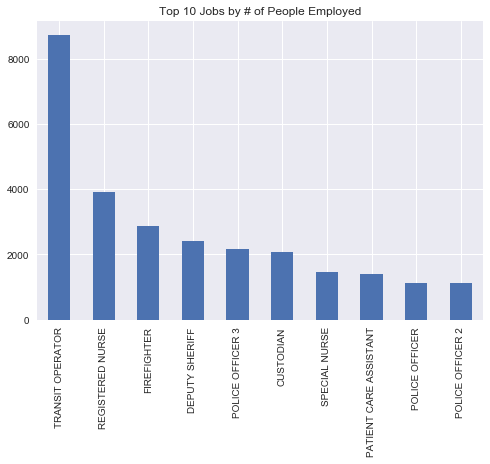

In [38]:
JobTitleCount = sf['JobTitle'].value_counts().head(10)
JobTitleCount.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

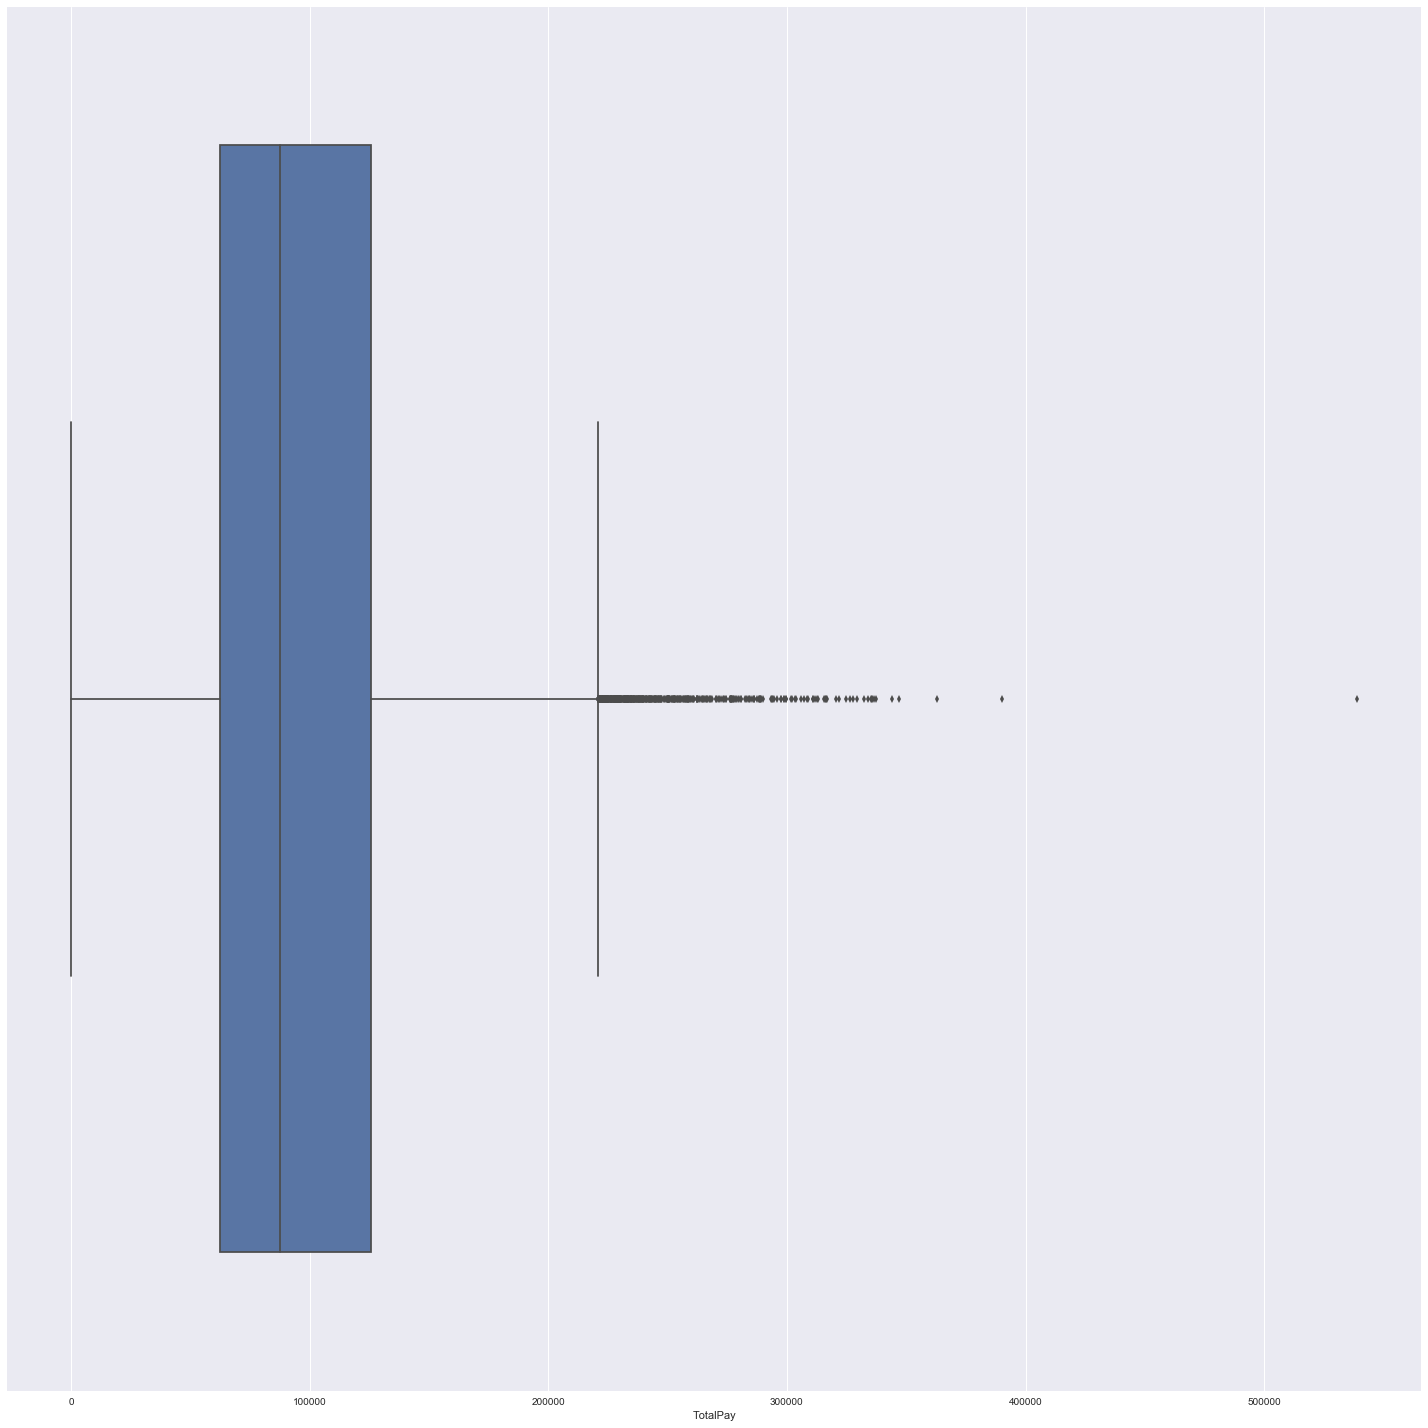

In [42]:
PayByYear = sns.FacetGrid(sf, size=20)
                          
                          #size=10, aspect=.5)
PayByYear = PayByYear.map(sns.boxplot, "TotalPay")

# If this tells us anything, is that there are some extreme outliers.

We can clearly see that there are some extreme outliers in this dataset.

Lets seperate the "High" and "Low" earners to look at them in greater detail.

In [43]:
HighEarners = sf[sf.TotalPay > 300000]
LowEarners = sf[sf.TotalPay < 4000]

In [44]:
pd.pivot_table(HighEarners, index=['JobTitle', 'EmployeeName', 'Year'], values=["TotalPay"])

TotalPay
JobTitle                                     EmployeeName       Year           
ASSISTANT DEPUTY CHIEF 2                     MARK KEARNEY       2012  327689.78
ASSISTANT DEPUTY CHIEF II                    DAVID SULLIVAN     2011  316285.74
ASST CHF OF DEPT (FIRE DEPT)                 DAVID FRANKLIN     2012  315728.77
                                             DAVID L FRANKLIN   2013  333888.32
                                                                2014  329390.54
                                             THOMAS A SIRAGUSA  2013  324820.63
ASST MED EXAMINER                            AMY P HART         2014  390111.98
                                             ELLEN G MOFFATT    2013  335537.96
                                                                2014  344187.46
BATTALION CHIEF, (FIRE DEPARTMENT)           ALSON LEE          2011  315981.05
                                             MICHAEL MORRIS     2011  303427.55
BATTALION CHIEF, FIRE SUPPRESS               BRENDAN A WARD     2013  313142.24
                                             BRYAN W RUBENSTEIN 2013  311000.86
                                                                2014  306117.53
                                             JOSE L VELO        2014  307099.61
                                             LORRIE A KALOS     2013  301697.70
                                             MARK J JOHNSON     2013  311698.29
                                             MARTY A ROSS       2013  312616.60
                                             SAMSON  LAI        2013  347102.32
                                             SAMSON LAI         2014  335484.96
BATTLION CHIEF, FIRE SUPPRESSI               BRENDAN WARD       2012  321883.83
                                             MARTY ROSS         2012  310968.31
                                             RUDY CASTELLANOS   2012  316988.26
                                             SAMSON LAI         2012  316214.00
CAPTAIN 3                                    JOHN EHRLICH       2012  303869.82
CAPTAIN III (POLICE DEPARTMENT)              ALBERT PARDINI     2011  335279.91
                                             GARY JIMENEZ       2011  538909.28
CAPTAIN, FIRE SUPPRESSION                    MICHAEL ROLOVICH   2012  302002.06
                                             PHILIP STEVENS     2012  308669.82
DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT) PATRICK GARDNER    2011  326373.19
DEPUTY SHERIFF                               WHITNEY P YEE      2013  308434.84
ELECTRONIC MAINTENANCE TECH                  KHOA TRINH         2012  336393.73
EMT/PARAMEDIC/FIREFIGHTER                    FREDERICK BINKLEY  2012  337204.86
LIEUTENANT, FIRE SUPPRESSION                 GARY ALTENBERG     2012  362844.66
                                             GARY L ALTENBERG   2013  320375.79
WIRE ROPE CABLE MAINTENANCE MECHANIC         CHRISTOPHER CHONG  2011  332343.61

Above we see the 'JobTitles' and 'EmployeeNames' of the "High Earners", we additionally learn that many of them hold the position for more than one year.

We also see that JobTitles were slightly changed between years, and as a result the same jobs appear seperately, lets create a new field called 'Department' later to hone in and compare departments.

There is also the addition of a middle name initial which is creating duplication in data.

In [46]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [47]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"

In [48]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.ix[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.ix[:,0]/1000000]
ByDepartment.ix[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.ix[:,1]]
ByDepartment

,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
,"$2,799.85 MM","$83,010.00",33729
FIRE,$845.95 MM,"$158,270.00",5345
MEDICAL,$681.67 MM,"$98,407.00",6927
POLICE,$942.44 MM,"$128,766.00",7319
TRANSIT,$829.02 MM,"$75,428.00",10991


In the above table we can see the total, mean and count of Total Paid per Department

In [1]:
plt.scatter()

NameError: name 'plt' is not defined

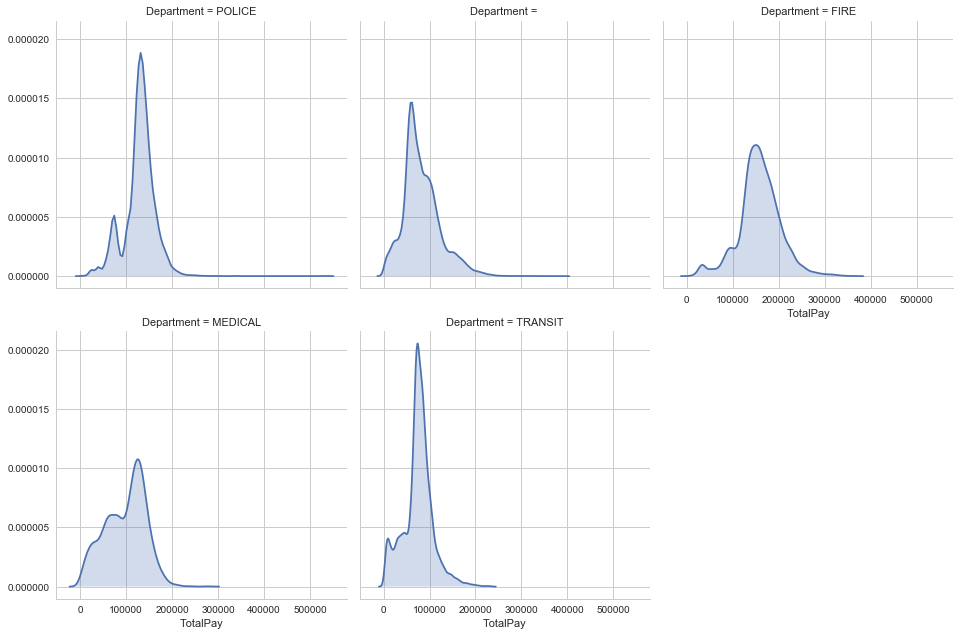

In [51]:
plot_jg = sns.FacetGrid(sf, col="Department", col_wrap=3, size=4.5, dropna=True)
plot_jg = plot_jg.map(sns.kdeplot, 'TotalPay', shade=True)

In the above grapth we can see that the Police Department employees earn the most money.

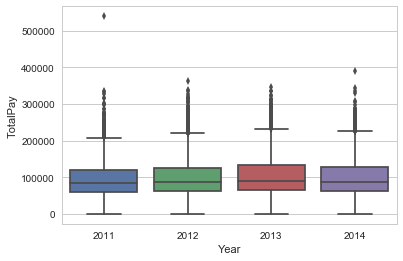

In [77]:
sns.boxplot(x="Year", y="TotalPay", data=sf)

Above we see that the salaries have not changed between the years.

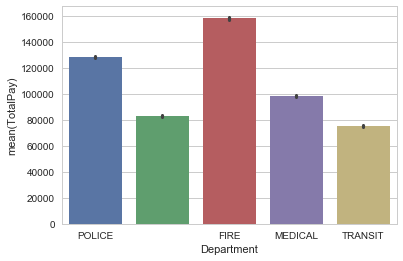

In [78]:
sns.barplot(x="Department", y="TotalPay", data=sf)

### ---------------------------- WORK ZONE --------------------------------

In [90]:
sf['FirstName'] = sf.EmployeeName.str.split(' ').str.get(0)

In [145]:
# There are 5188 unique names

len(sf.FirstName.unique())

5188

In [177]:
### Learned how to make a list out of a pd.Series

sf.FirstName.unique().tolist()

['GARY',
 'ALBERT',
 'CHRISTOPHER',
 'PATRICK',
 'DAVID',
 'ALSON',
 'MICHAEL',
 'ARTHUR',
 'PATRICIA',
 'RICHARD',
 'SEBASTIAN',
 'MARTY',
 'ELLEN',
 'JUDY',
 'GEORGE',
 'VICTOR',
 'JOSEPH',
 'JOHN',
 'RAYMOND',
 'JOSE',
 'KHOA',
 'JAMES',
 'JONES',
 'BRENDAN',
 'THOMAS',
 'BRYAN',
 'KEN',
 'KIRK',
 'DARRYL',
 'RAY',
 'DOUGLAS',
 'AI-KYUNG',
 'KENNETH',
 'ANNA',
 'CHARLES',
 'GREGORY',
 'ROBERT',
 'EDWARD',
 'WING',
 'LAWRENCE',
 'ANTONIO',
 'MARK',
 'KEVIN',
 'BERT',
 'EDUARDO',
 'LORRIE',
 'JONATHAN',
 'EVETTE',
 'MARY',
 'DONNA',
 'PETE',
 'REX',
 'SARAH',
 'ERIKA',
 'LAUIFI',
 'PATRIC',
 'SAMSON',
 'SCOTT',
 'C',
 'LISETTE',
 'KHAIRUL',
 'SHELLEY',
 'SEAN',
 'TYRONNE',
 'SHARON',
 'SHANNON',
 'GLEN',
 'EDMUND',
 'WILLIAM',
 'ZACHARY',
 'LUIS',
 'GERALD',
 'DONNIE',
 'ANTHONY',
 'TIM',
 'RASMI',
 'MATTHEW',
 'WHITNEY',
 'STEVEN',
 'EDGAR',
 'L',
 'HAROLD',
 'KARL',
 'OSCAR',
 'MARTIEN',
 'CARL',
 'AMPARO',
 'HARRY',
 'ALBERTO',
 'DWAYNE',
 'LEON',
 'DONALD',
 'NATHAN',
 'KIRSTEN',


In [232]:
### Below I am trying to get unique names into either a single 
### dataframe to loop into URL or list of names seperated by ";"

In [233]:
sf_names = sf.groupby('FirstName').size().sort_values(ascending=False)[0:500]
sf_names = sf_names.to_frame()
### Here I am trying to rename the header so that I can alienate index = 0
### sf_names.columns = ["FirstName", "Count"]

In [130]:
# Here we will utilize the gender-api.com to obtain the sex from the FirstName column

import json
from urllib.request import urlopen

In [110]:
myKey = "TAwMTNVKfmMTYLWcbU"

In [147]:
url = "https://gender-api.com/get?key=" + myKey + "&name=SHOU;LOURNA"

In [148]:
response = urlopen(url)

In [149]:
decoded = response.read().decode('utf-8')

In [150]:
data = json.loads(decoded)

In [157]:
data

{'duration': '15ms',
 'name': 'shou;lourna',
 'result': [{'accuracy': 92,
   'gender': 'female',
   'name': 'lourna',
   'samples': 12},
  {'accuracy': 80, 'gender': 'male', 'name': 'shou', 'samples': 203}]}

In [153]:
import json
from pandas.io.json import json_normalize

In [158]:
json_normalize(data, 'result')

,accuracy,gender,name,samples
0,92,female,lourna,12
1,80,male,shou,203


In [123]:
print( "Gender: " + data["gender"]); #Gender: male

Gender: female


### -----------------------------------------------------------------------------------------------

In [39]:
# Can you compare two related quantities?

In [43]:
# Can you make a scatterplot?

In [44]:
# Can you make a time-series plot?

In [45]:
# How have salaries changed over time between different groups of people?

In [46]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [47]:
# Can we split the dataset between males and females?

In [48]:
# Is there any evidene of pay discrimination based on gender in this dataset?

In [49]:
# How is budget allocated based on different groups and responsibilities?

In [50]:
# Any 80/20 principals I can identify?

In [51]:
# Integrate ideas from here:
# https://public.tableau.com/profile/lawrence.chernin#!/vizhome/SanFranciscoSalaries/CountsbyTitle

## Questions to Explore

In [33]:
# Are there any duplicate names in the dataset?

In [34]:
# Which employee has been employed three years?

In [35]:
# What is the correlation between titles and salaries?